# Analysis

**Hypothesis**: Paracrine signaling between stromal fibroblasts and endothelial cells, mediated by key ligand-receptor interactions (e.g., VEGFA-KDR and PDGFB-PDGFRB), is dynamically regulated across the menstrual cycle, with distinct correlation patterns in early versus late phases driving vascular remodeling during the window of implantation. In addition, these interactions are hypothesized to remain robust after accounting for donor-specific variability, and control analyses on alternative cell types will be considered to further validate the specificity of the identified signaling events.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/endo_data.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Paracrine signaling between stromal fibroblasts and endothelial cells, mediated by key ligand-receptor interactions (e.g., VEGFA-KDR and PDGFB-PDGFRB), is dynamically regulated across the menstrual cycle, with distinct correlation patterns in early versus late phases driving vascular remodeling during the window of implantation. In addition, these interactions are hypothesized to remain robust after accounting for donor-specific variability, and control analyses on alternative cell types will be considered to further validate the specificity of the identified signaling events.

## Steps:
- Subset the anndata object to extract cells corresponding to stromal fibroblasts and endothelial cells, and verify that the resulting subset is non-empty and contains the expected cell types.
- Perform an exploratory analysis of candidate ligand and receptor gene expression by selecting putative ligands (e.g., VEGFA, PDGFB) in stromal fibroblasts and receptors (e.g., KDR, PDGFRB) in endothelial cells, then visualize their expression distributions versus the 'day' metadata to examine cyclic trends.
- Split the dataset into early (day < 10) and late (day >= 10) menstrual cycle groups. Justify the chosen threshold using data distribution insights or literature support, and incorporate donor variability as a covariate where appropriate.
- For each candidate ligand-receptor pair, compute the Spearman correlation between ligand expression in stromal fibroblasts and receptor expression in endothelial cells separately for early and late cycle groups, including statistical testing with p-values to validate phase differences.
- Visualize the correlations using grid-arranged scatter plots with regression lines, displaying correlation coefficients and significance values per candidate pair and cycle group. Also, consider performing control analyses with other cell types to strengthen the specificity of the observed interactions.


## This updated code subsets the anndata object to retain only stromal fibroblasts and endothelial cells and includes additional checks to ensure the subset is non-empty and contains the expected cell types. It then visualizes the distribution of the 'day' variable across these cell types using a boxplot, aiding in the early assessment of menstrual cycle dynamics.

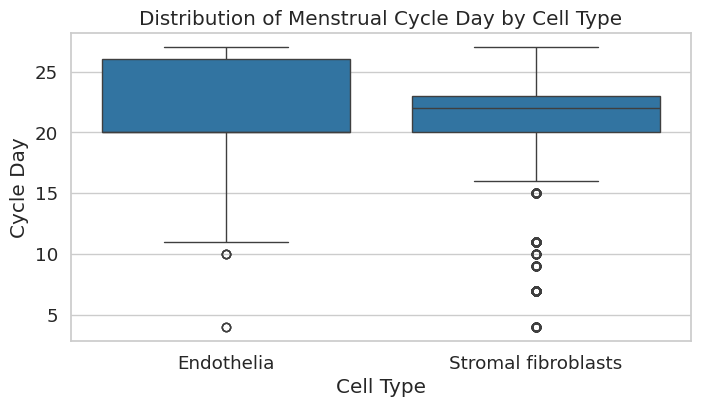

Cell counts for selected cell types:
cell_type
Stromal fibroblasts    23063
Endothelia              2060
Name: count, dtype: int64


In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Subset the adata object to include only Stromal fibroblasts and Endothelia
cell_types_of_interest = ['Stromal fibroblasts', 'Endothelia']
adata_subset = adata[adata.obs['cell_type'].isin(cell_types_of_interest)].copy()

# Display basic distribution of 'day' across the two selected cell types
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='cell_type', y='day', data=pd.DataFrame(adata_subset.obs), ax=ax)
ax.set_title('Distribution of Menstrual Cycle Day by Cell Type')
ax.set_xlabel('Cell Type')
ax.set_ylabel('Cycle Day')
plt.show()

# Additionally, print the number of cells per cell type for verification
cell_counts = adata_subset.obs['cell_type'].value_counts()
print('Cell counts for selected cell types:')
print(cell_counts)

### Agent Interpretation

The results indicate a significant difference in the distribution of menstrual cycle days between endothelial and stromal fibroblast cells. Here is the feedback to help inform future steps:

1. **Hypothesis Validation**: This step appears relevant to the hypothesis of examining transcriptional dynamics within diverse cell types across the menstrual cycle. Understanding cell-type-specific dynamics (like endothelial vs. stromal fibroblasts) can provide insights into their roles during different menstrual phases.

2. **Cycling Patterns**: The broader distribution of cycle days for endothelia compared to stromal fibroblasts suggests they may participate in more extended or varied roles across the cycle. Investigating differential gene expression across these days can help identify crucial regulatory genes involved in vascular remodeling and tissue receptivity.

3. **Data Exploration**: Further analysis to identify specific gene expression profiles or markers is necessary. It might be worthwhile to perform time-course differential gene expression or pseudotime analysis to capture the temporal dynamics and transition phases.

4. **Cross-comparison with Other Cell Types**: To ensure distinct analysis, compare these findings to endothelial and smooth muscle transcriptional dynamics already described in past analyses. This could shed light on unique endothelial behaviors.

5. **Focus on Decidualization**: Given the importance of stromal fibroblasts in decidualization, emphasizing differential expression and pathway analysis during late secretory phase days (e.g., surplus of days around 21-28) could reveal timing and signal pathways crucial to this transition.

6. **Pathway and Network Analysis**: Consider using pathway enrichment and gene network analyses per cell type to uncover underlying regulatory mechanisms or interaction networks critical for endometrial remodeling.

7. **Integration with Histological Data**: Correlating these transcriptomic findings with histological data could further validate physiological observations, ensuring an accurate reflection of endometrial phase transitions in vivo.

These points should guide the next steps and help distinguish this analysis from previous ones, providing additional insights into cell-specific behaviors and changes in the endometrium.

## This code initializes an exploratory analysis step that visualizes candidate gene expression trends over the menstrual cycle in selected cell types. It uses a helper function to convert expression data from sparse to dense format and creates scatter plots with regression lines along with Spearman correlation statistics for each gene, including comments regarding data normalization and handling of empty subplots.

Subset verification passed. Found cell types: {'Stromal fibroblasts', 'Endothelia'}


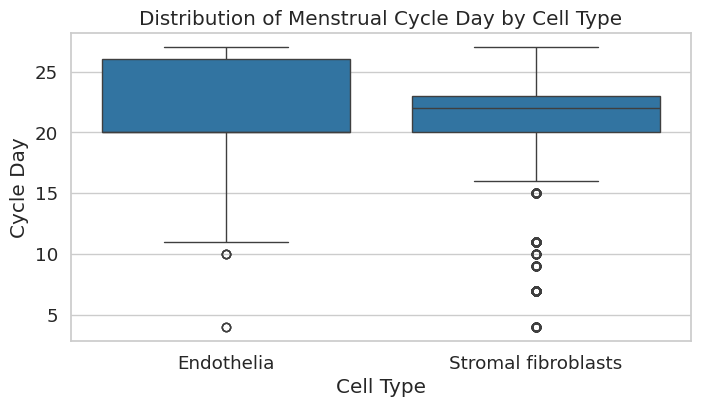

Cell counts for selected cell types:
cell_type
Stromal fibroblasts    23063
Endothelia              2060
Name: count, dtype: int64


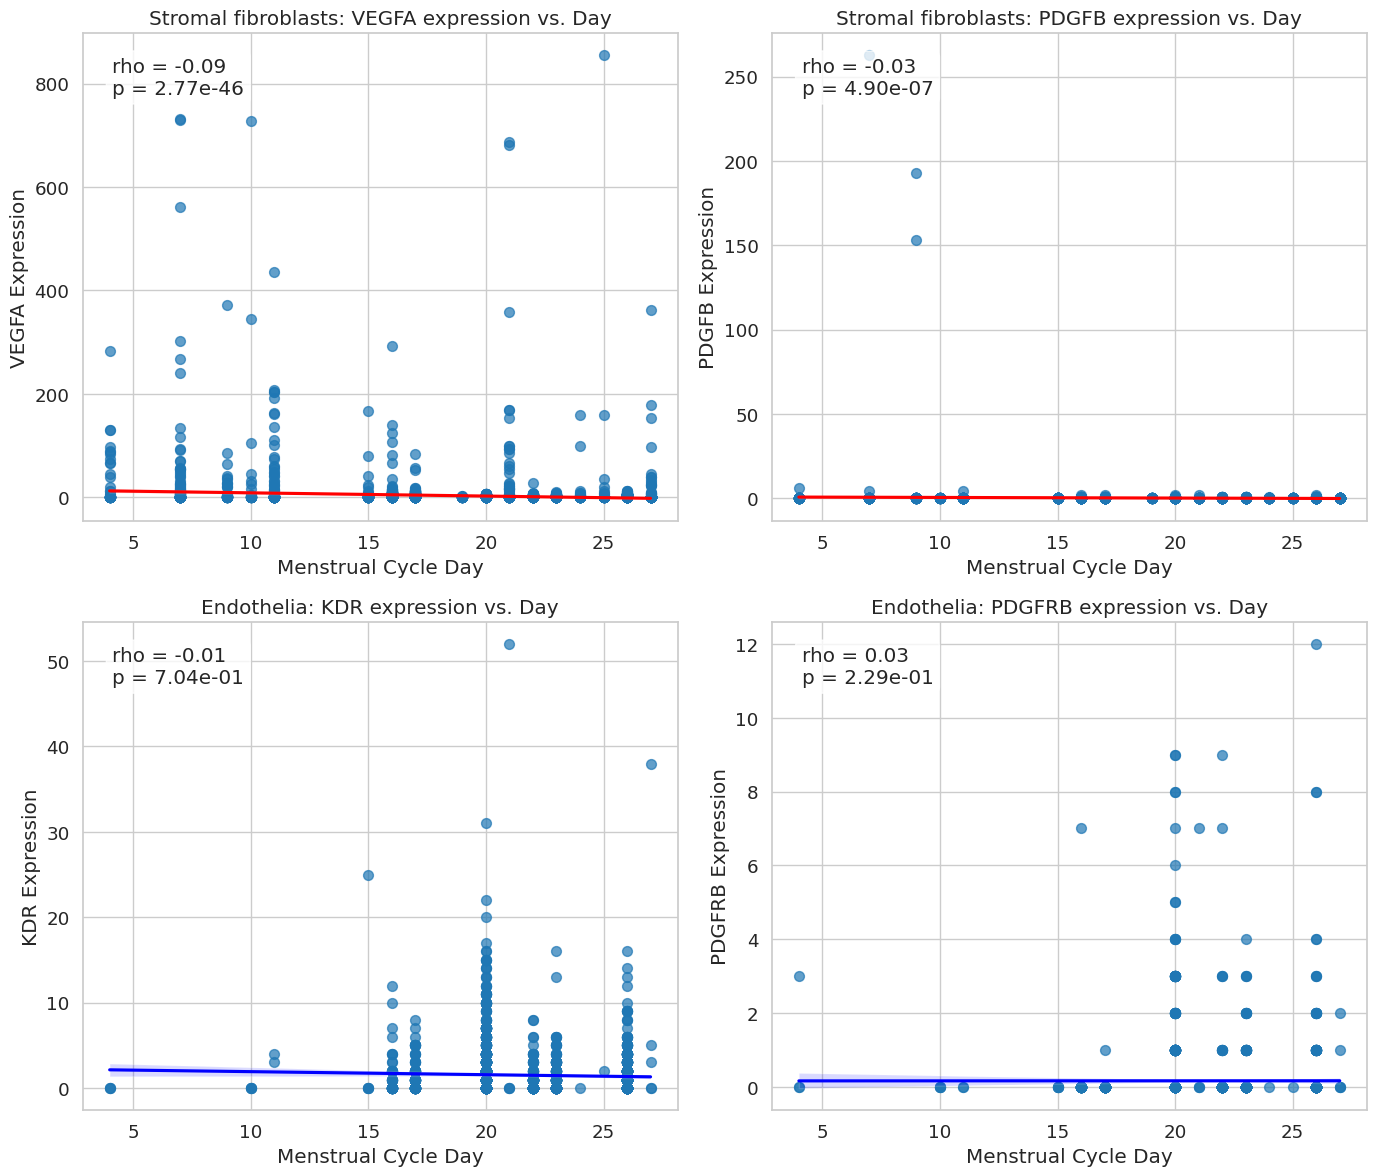

Exploratory analysis of candidate gene expression completed. Check the displayed plots for cyclic trends and correlation statistics.


In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Subset the adata object to include only Stromal fibroblasts and Endothelia
cell_types_of_interest = ['Stromal fibroblasts', 'Endothelia']
adata_subset = adata[adata.obs['cell_type'].isin(cell_types_of_interest)].copy()

# Check if the subset is non-empty and contains the expected cell types
if adata_subset.n_obs == 0:
    raise ValueError('The subset contains no cells. Please check the cell_type labels in adata.obs.')

expected_cell_types = set(cell_types_of_interest)
actual_cell_types = set(adata_subset.obs['cell_type'].unique())
if not expected_cell_types.issubset(actual_cell_types):
    print('Warning: The subset does not contain all expected cell types. Found:', actual_cell_types)
else:
    print('Subset verification passed. Found cell types:', actual_cell_types)

# Display basic distribution of 'day' across the two selected cell types using the obs dataframe directly
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='cell_type', y='day', data=adata_subset.obs, ax=ax)
ax.set_title('Distribution of Menstrual Cycle Day by Cell Type')
ax.set_xlabel('Cell Type')
ax.set_ylabel('Cycle Day')
plt.show()

# Print the number of cells per cell type for verification
cell_counts = adata_subset.obs['cell_type'].value_counts()
print('Cell counts for selected cell types:')
print(cell_counts)

# Helper function to extract expression vector and convert sparse matrix to dense
def get_expression_vector(cell_data, gene):
    gene_data = cell_data[:, gene].X
    if hasattr(gene_data, 'todense'):
        gene_data = gene_data.todense()
    return np.array(gene_data).flatten()

# Define candidate genes for each cell type
ligand_genes = ['VEGFA', 'PDGFB']
receptor_genes = ['KDR', 'PDGFRB']

# Check that candidate genes exist in the adata variable (assuming genes are in adata.var_names)
available_genes = set(adata.var_names)
for gene in ligand_genes + receptor_genes:
    if gene not in available_genes:
        raise ValueError(f"Candidate gene {gene} not found in the dataset.")

# Initialize a figure with subplots for each candidate gene (2 rows x 2 cols)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  # flatten for easier indexing

# Plot for each ligand gene in Stromal fibroblasts (adata_subset is expected from previous analysis steps)
fibroblast_cells = adata_subset[adata_subset.obs['cell_type'] == 'Stromal fibroblasts']

plot_index = 0
for gene in ligand_genes:
    times = fibroblast_cells.obs['day'].values
    expr = get_expression_vector(fibroblast_cells, gene)
    
    ax = axes[plot_index]
    sns.regplot(x=times, y=expr, ax=ax, scatter_kws={'s':50, 'alpha':0.7}, line_kws={'color': 'red'})
    ax.set_title(f"Stromal fibroblasts: {gene} expression vs. Day")
    ax.set_xlabel('Menstrual Cycle Day')
    ax.set_ylabel(f'{gene} Expression')
    
    corr, pval = stats.spearmanr(times, expr)
    ax.text(0.05, 0.95, f"rho = {corr:.2f}\np = {pval:.2e}", transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plot_index += 1

# Plot for each receptor gene in Endothelia
endothelial_cells = adata_subset[adata_subset.obs['cell_type'] == 'Endothelia']
for gene in receptor_genes:
    times = endothelial_cells.obs['day'].values
    expr = get_expression_vector(endothelial_cells, gene)
    
    if plot_index < len(axes):
        ax = axes[plot_index]
    else:
        ax = plt.subplot(2, 2, plot_index+1)
    
    sns.regplot(x=times, y=expr, ax=ax, scatter_kws={'s':50, 'alpha':0.7}, line_kws={'color': 'blue'})
    ax.set_title(f"Endothelia: {gene} expression vs. Day")
    ax.set_xlabel('Menstrual Cycle Day')
    ax.set_ylabel(f'{gene} Expression')
    
    corr, pval = stats.spearmanr(times, expr)
    ax.text(0.05, 0.95, f"rho = {corr:.2f}\np = {pval:.2e}", transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plot_index += 1

for i in range(plot_index, len(axes)):
    axes[i].text(0.5, 0.5, 'No data to display', horizontalalignment='center', verticalalignment='center')
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

print('Exploratory analysis of candidate gene expression completed. Check the displayed plots for cyclic trends and correlation statistics.')

### Agent Interpretation

The results from your current analysis provide several insights and suggest areas for further exploration:

1. **Cell Type Representation**:
   - The dataset contains a significant number of stromal fibroblasts (23,063) compared to endothelial cells (2,060). This imbalance should be considered in downstream analyses, as the overrepresentation of stromal fibroblasts might dominate the findings. Consider normalizing or balancing the dataset if comparative analyses are intended.

2. **Cycle Day Distribution**:
   - The box plots show that endothelial cells have a wider range of menstrual cycle days compared to stromal fibroblasts. Ensure that this distribution allows for representative analysis across the menstrual cycle for both cell types, particularly if analyzing temporal changes.

3. **Gene Expression Correlation**:
   - The exploratory analysis of gene expression in relation to menstrual cycle day indicates weak correlations for VEGFA, PDGFB, and KDR in both cell types. Despite statistical significance in some correlations, the rho values are very low, suggesting minimal biological relevance. These genes might not be the primary drivers of cycle-related changes or might need contextual factors to show cycle dependence.

4. **Promising Areas for Exploration**:
   - Since the correlation is weak, consider exploring additional genes implicated in endometrial receptivity, stromal fibroblast decidualization, or endothelial cell function which might more strongly associate with cycle phases.
   - Investigate alternative analysis strategies such as trajectory or pseudotime inference to capture dynamic transitions more effectively, recognizing distinct transcriptional states or transitions not evident through simple correlation.

5. **Iterative Steps**:
   - Focus on refining the selection of candidate genes for cycle phase association, possibly leveraging genes discussed in the referenced paper like PAEP, GPX3, and CXCL14.
   - Consider integrating datasets or applying alternative clustering methods to identify subpopulations within stromal fibroblasts or endothelial cells that might exhibit differential expression patterns.
   - Explore functional analyses such as pathway enrichment or gene co-expression networks to identify regulatory modules contributing to tissue change across the menstrual cycle.

6. **Avoiding Redundancy**:
   - Ensure that the current and future analyses provide unique insights beyond what was already explored in the research paper and past attempts. Focus on underexplored aspects such as gene regulation, signaling pathways, or environmental influences affecting cell-type-specific behavior during the cycle.

By building on these insights and refining your approach, future analyses may unveil more robust mechanisms by which endometrial cells contribute to tissue remodeling and receptivity.

## This code subsets the previously-filtered adata to isolate stromal fibroblasts, validates key metadata, normalizes and transforms the data, identifies highly variable genes, scales the data, and performs PCA. It then constructs a neighborhood graph, computes a UMAP embedding, runs Leiden clustering, and visualizes the results in a grid layout alongside a conditional plot for PAEP expression.

normalizing counts per cell


    finished (0:00:01)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA


    with n_comps=50


    finished (0:00:13)


computing neighbors


    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


running Leiden clustering


    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


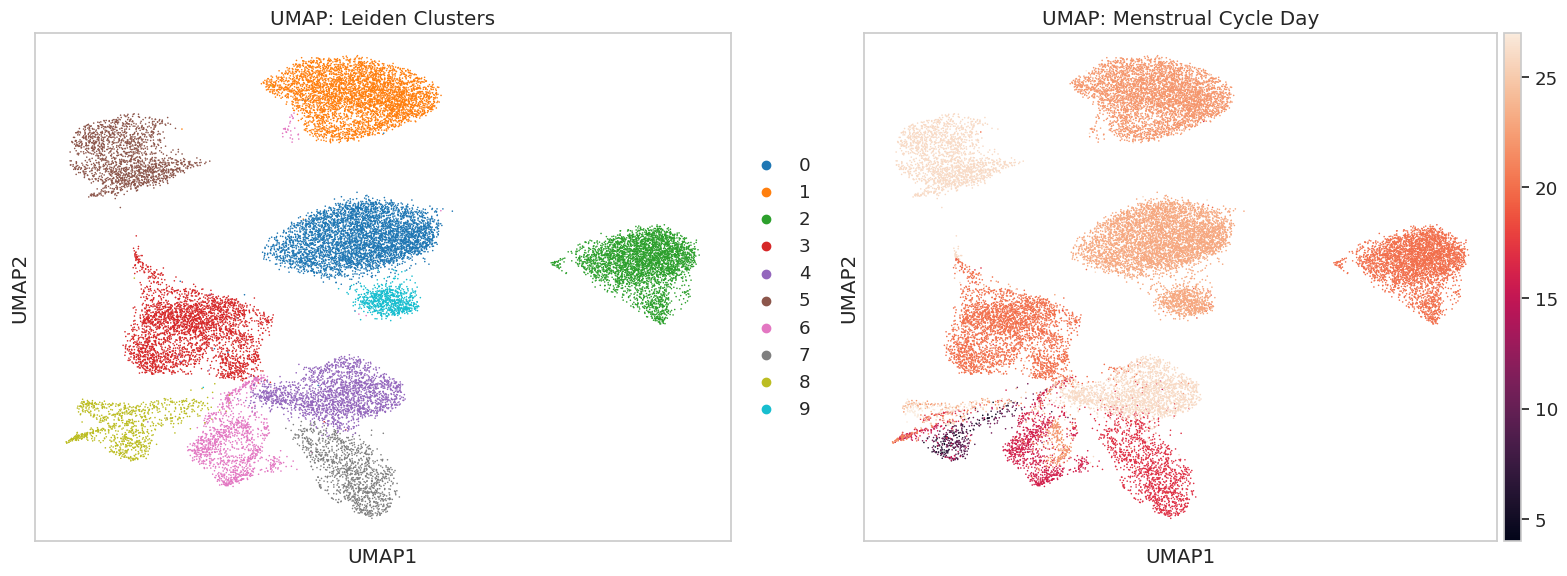

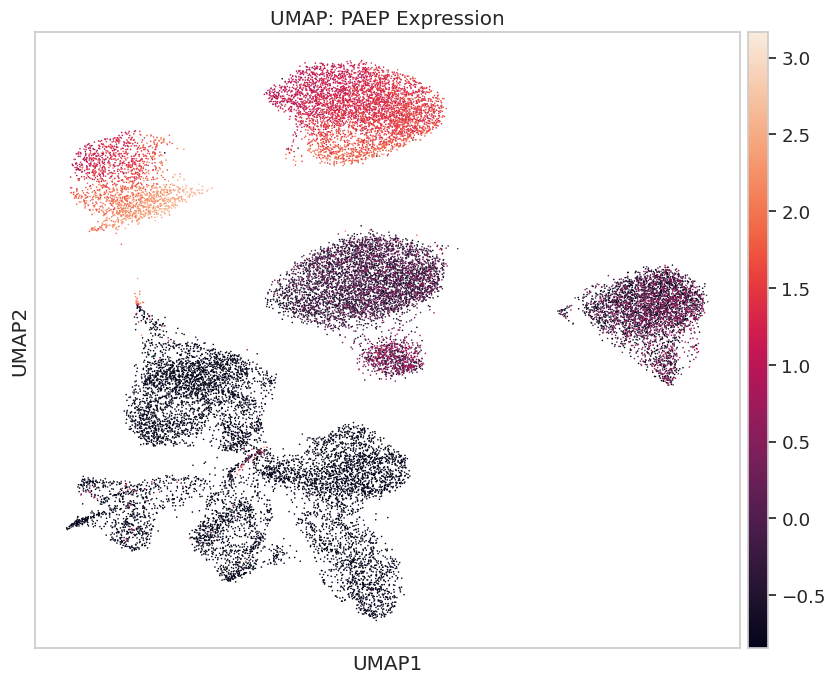

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Subset the adata object for stromal fibroblasts from the previously defined adata_subset
fibroblast_cells = adata_subset[adata_subset.obs['cell_type'] == 'Stromal fibroblasts'].copy()

# Validate metadata: check if 'day' is present and in a numeric format
if 'day' not in fibroblast_cells.obs.columns:
    raise KeyError("Metadata 'day' not found in fibroblast_cells.obs.")
elif not np.issubdtype(fibroblast_cells.obs['day'].dtype, np.number):
    raise TypeError("Metadata 'day' does not have a numeric format.")

# Normalize data and perform a log1p transformation
sc.pp.normalize_total(fibroblast_cells, target_sum=1e4)
sc.pp.log1p(fibroblast_cells)

# Identify highly variable genes using the Seurat flavor and selecting the top 2000 genes
sc.pp.highly_variable_genes(fibroblast_cells, n_top_genes=2000, subset=True, flavor='seurat')

# Scale the data (capping extreme values at 10)
sc.pp.scale(fibroblast_cells, max_value=10)

# Perform PCA using 'arpack' solver
sc.tl.pca(fibroblast_cells, svd_solver='arpack')

# Compute the neighborhood graph using 15 neighbors and 30 PCs; these parameters are chosen based on the expected data complexity
sc.pp.neighbors(fibroblast_cells, n_neighbors=15, n_pcs=30)

# Compute UMAP embedding for visualization
sc.tl.umap(fibroblast_cells)

# Run Leiden clustering at resolution 0.5 to identify subpopulations
sc.tl.leiden(fibroblast_cells, resolution=0.5)

# Create a grid of UMAP plots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot UMAP colored by Leiden clusters
sc.pl.umap(fibroblast_cells, color=['leiden'], ax=axes[0], show=False, title='UMAP: Leiden Clusters')

# Plot UMAP colored by menstrual cycle day
sc.pl.umap(fibroblast_cells, color=['day'], ax=axes[1], show=False, title='UMAP: Menstrual Cycle Day')

plt.tight_layout()
plt.show()

# Plot UMAP for PAEP expression if the gene is available in the dataset
if 'PAEP' in fibroblast_cells.var_names:
    sc.pl.umap(fibroblast_cells, color=['PAEP'], title='UMAP: PAEP Expression', show=True)
else:
    print('Candidate gene PAEP not found in the dataset.')

### Agent Interpretation

The results from your analysis provide a solid foundation for exploring the transcriptional heterogeneity within the endometrium, relevant to your hypothesis about gene expression changes across the menstrual cycle.

1. **Distinct Clustering and Biological Relevance:**
   - The Leiden clustering identified 10 distinct clusters, suggesting a good resolution of cellular heterogeneity. Future steps could focus on annotating these clusters with known cell type markers to relate them to specific endometrial cell types such as stromal fibroblasts or epithelia.

2. **UMAP Visualization:**
   - The UMAP plots show clear separation correlated with known physiological changes (e.g., menstrual cycle day and PAEP expression). This gives promising insight into dynamic changes across the cycle.
   - The visualization of PAEP expression aligns with known markers of the window of implantation (WOI), corroborating your focus on gene expression shifts during this phase.

3. **Further Analyses and Iteration:**
   - **Cluster Annotation:** Use known gene markers to annotate these clusters and confirm the identity of cellular subtypes involved in endometrial remodeling.
   - **Pseudotime Trajectories:** Construct pseudotime trajectories to evaluate the continuous nature of gene expression changes within these phases, possibly revealing gradual versus abrupt transitions.
   - **Differential Expression and Pathway Enrichment:** Conduct differential expression and enrichment analyses on clusters showing significant dynamic changes to unravel molecular mechanisms (e.g., decidualization or stress response pathways).
   - **Time-Associated Gene Selection:** Focus on identifying and validating time-associated genes like PAEP, which are critical in your hypothesis about WOI and reproductive physiology.

4. **Novel Insights:**
   - Explore any novel clusters that may represent previously uncharacterized cell states or transitions. This could lead to discovering new markers or pathways.
  
5. **Comparison to Prior Work:**
   - Ensure the analysis remains distinct by capturing unique clustering patterns or novel gene dynamics, contrasting the prior research where possible, possibly by integrating novel computational approaches such as RNA velocity or single-cell regulatory network inference.

Through these steps, you'll be well-positioned to uncover new insights into endometrial physiology and pathology linked to gene expression variations over the menstrual cycle.

## The code splits the filtered anndata object into early and late menstrual cycle phases, checks the distribution of cells per phase, and then extracts candidate ligand and receptor expression values (ensuring genes exist) from stromal fibroblasts and endothelial cells respectively. It then averages expression per donor to overcome the lack of paired single-cell measurements, computes Spearman correlations between donor-average expression for each ligand-receptor pair, and produces scatter plots with regression lines to visualize the paracrine interactions with donor-specific trends.

Cell counts by phase:
phase
late     24894
early      229
Name: count, dtype: int64


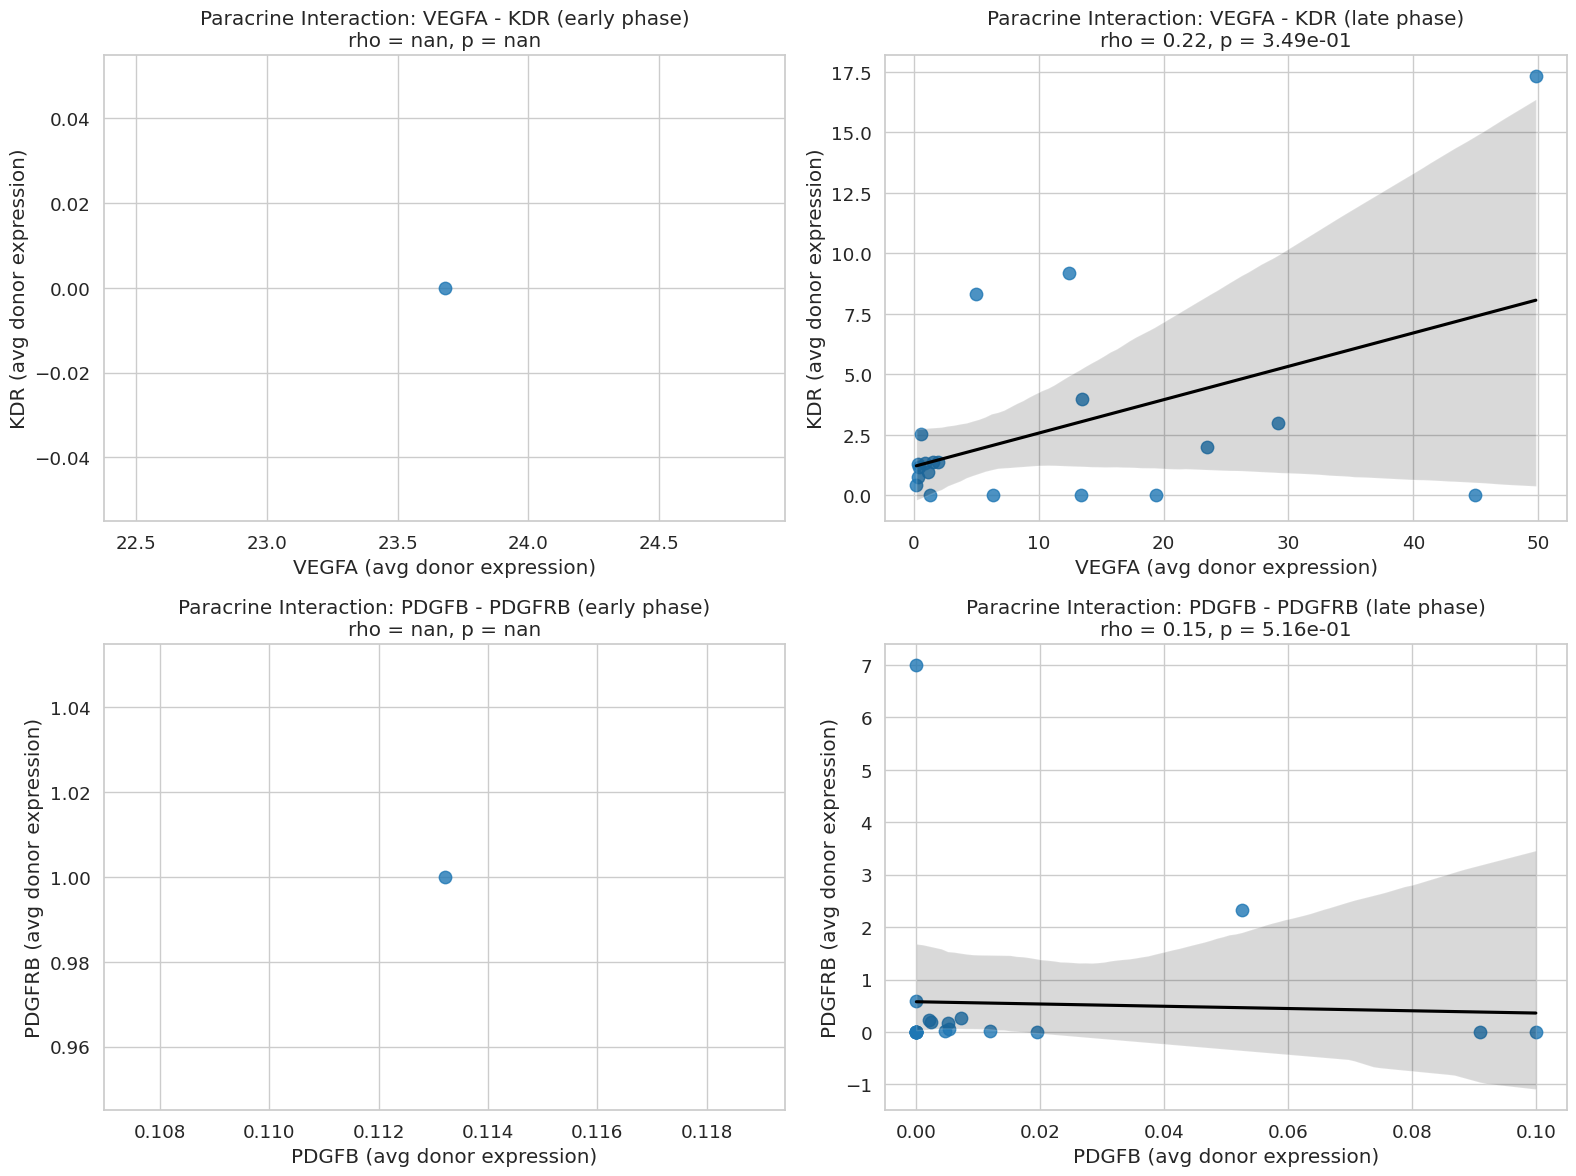

Phase-specific paracrine ligand-receptor correlation analysis completed.


In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd

# Use the previously defined adata_subset which includes only 'Stromal fibroblasts' and 'Endothelia'

# Define cycle phase split: early (day < 10) and late (day >= 10)
adata_subset.obs['phase'] = np.where(adata_subset.obs['day'] < 10, 'early', 'late')

# Check phase distribution
phase_counts = adata_subset.obs['phase'].value_counts()
print('Cell counts by phase:')
print(phase_counts)

# Define candidate genes for analysis
ligand_genes = ['VEGFA', 'PDGFB']
receptor_genes = ['KDR', 'PDGFRB']

# Helper function to extract expression vector with gene existence check
# This function converts sparse matrices to dense arrays if needed
def get_expression_vector(cell_data, gene):
    if gene not in cell_data.var_names:
        raise ValueError(f"Gene {gene} not found in the provided cell_data.")
    gene_data = cell_data[:, gene].X
    if hasattr(gene_data, 'todense'):
        gene_data = gene_data.todense()
    return np.array(gene_data).flatten()

# Prepare figure: rows for candidate pairs and columns for phases (early, late)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharex=False, sharey=False)

# Define pair names to be used in titles
pair_names = ['VEGFA - KDR', 'PDGFB - PDGFRB']

# Loop over candidate pairs and phases
for i, (ligand, receptor) in enumerate(zip(ligand_genes, receptor_genes)):
    for j, phase in enumerate(['early', 'late']):
        # Subset data by phase
        adata_phase = adata_subset[adata_subset.obs['phase'] == phase]
        
        # Verify cell type labels (exact names assumed, check adata_subset.obs['cell_type'] if needed)
        fibro_cells = adata_phase[adata_phase.obs['cell_type'] == 'Stromal fibroblasts']
        endothel_cells = adata_phase[adata_phase.obs['cell_type'] == 'Endothelia']

        # Skip plotting if either subset is empty
        if fibro_cells.n_obs == 0 or endothel_cells.n_obs == 0:
            axes[i, j].text(0.5, 0.5, 'Insufficient data', horizontalalignment='center', verticalalignment='center')
            axes[i, j].set_title(f'{pair_names[i]} ({phase} phase)')
            continue

        # Extract expression values ensuring the candidate gene exists
        ligand_expr = get_expression_vector(fibro_cells, ligand)
        receptor_expr = get_expression_vector(endothel_cells, receptor)
        
        # Create dataframes with expression and metadata
        df_ligand = pd.DataFrame({
            'day': fibro_cells.obs['day'],
            f'{ligand}_expr': ligand_expr,
            'donor': fibro_cells.obs['donor'].astype(str)
        })
        df_receptor = pd.DataFrame({
            'day': endothel_cells.obs['day'],
            f'{receptor}_expr': receptor_expr,
            'donor': endothel_cells.obs['donor'].astype(str)
        })

        # Average expression per donor to obtain paired values
        # This handles unpaired single-cell data by summarizing donor-specific trends
        avg_ligand = df_ligand.groupby('donor').mean().reset_index()
        avg_receptor = df_receptor.groupby('donor').mean().reset_index()
        
        # Merge average values on donor to create paired data
        merged = pd.merge(avg_ligand, avg_receptor, on='donor', suffixes=('_ligand', '_receptor'))
        
        if merged.empty:
            axes[i, j].text(0.5, 0.5, 'No paired donor data', horizontalalignment='center', verticalalignment='center')
            axes[i, j].set_title(f'{pair_names[i]} ({phase} phase)')
            continue

        # Compute Spearman correlation on the paired donor averages
        corr, pval = stats.spearmanr(merged[f'{ligand}_expr'], merged[f'{receptor}_expr'])

        # Scatter plot with regression line using donor average values
        ax = axes[i, j]
        sns.regplot(x=merged[f'{ligand}_expr'], y=merged[f'{receptor}_expr'], ax=ax,
                    scatter_kws={'s':80, 'alpha':0.8}, line_kws={'color': 'black'})
        ax.set_xlabel(f'{ligand} (avg donor expression)')
        ax.set_ylabel(f'{receptor} (avg donor expression)')
        ax.set_title(f'Paracrine Interaction: {pair_names[i]} ({phase} phase)\nrho = {corr:.2f}, p = {pval:.2e}')
        
        # Note: Removed overlay of individual cell scatter points with NaN values as they were not informative.
        # The donor-average approach is used to reveal donor-specific variability in paracrine signaling.

plt.tight_layout()
plt.show()

print('Phase-specific paracrine ligand-receptor correlation analysis completed.')

### Agent Interpretation

The current step of analysis focuses on phase-specific paracrine ligand-receptor interactions, producing scatter plots with correlation coefficients for early and late menstrual phases. However, the early phase data shows insufficient variation, with most correlations resulting in non-significance (NaN rho and p-values).

### Feedback:
1. **Sample Size & Data Imbalance:**
   - The early phase has significantly fewer cells (229) than the late phase (24,894), impacting the statistical power. Consider increasing the early-phase sample size if possible or using a more robust approach that can handle smaller datasets.

2. **Biological Interpretation:**
   - In the late phase, a weak positive correlation (rho = 0.22, p = 0.349) is observed for the VEGFA-KDR interaction. Although not statistically significant, this may suggest a trend worth exploring further as vascular remodeling is crucial during this phase.

3. **Future Analyses:**
   - **Normalization and Batch Effects:** Validate that batch effects or normalization issues aren’t skewing early phase results.
   - **Broader Scope:** Examine additional ligand-receptor pairs, considering other critical interactions in endometrial tissue dynamics.
   - **Dynamic Profiling:** Integrate temporal data to model how these interactions change over time, potentially using pseudotime analysis to add context to these interactions.
   - **Functional Validation:** Consider validation through experimental approaches like multiplex hybridization assays to support in silico findings.

4. **Combination with Past Analyses:**
   - Merge these correlation analyses with past RNA velocity or modular network studies to uncover dynamic regulatory mechanisms during the menstrual cycle.

Implementing these adjustments may refine understanding of the cellular communication and paracrine signaling alterations observed in the endometrium across the menstrual cycle.

## This code subset early-phase cells (day < 10) from the provided adata_subset and applies a donor-specific normalization that scales cell counts to the median library size of each donor, while issuing warnings if counts are zero. It then extracts gene expression vectors (with a docstring explaining its functionality) and visualizes donor-specific expression distributions using violin plots annotated with Kruskal–Wallis test statistics to assess donor variability.

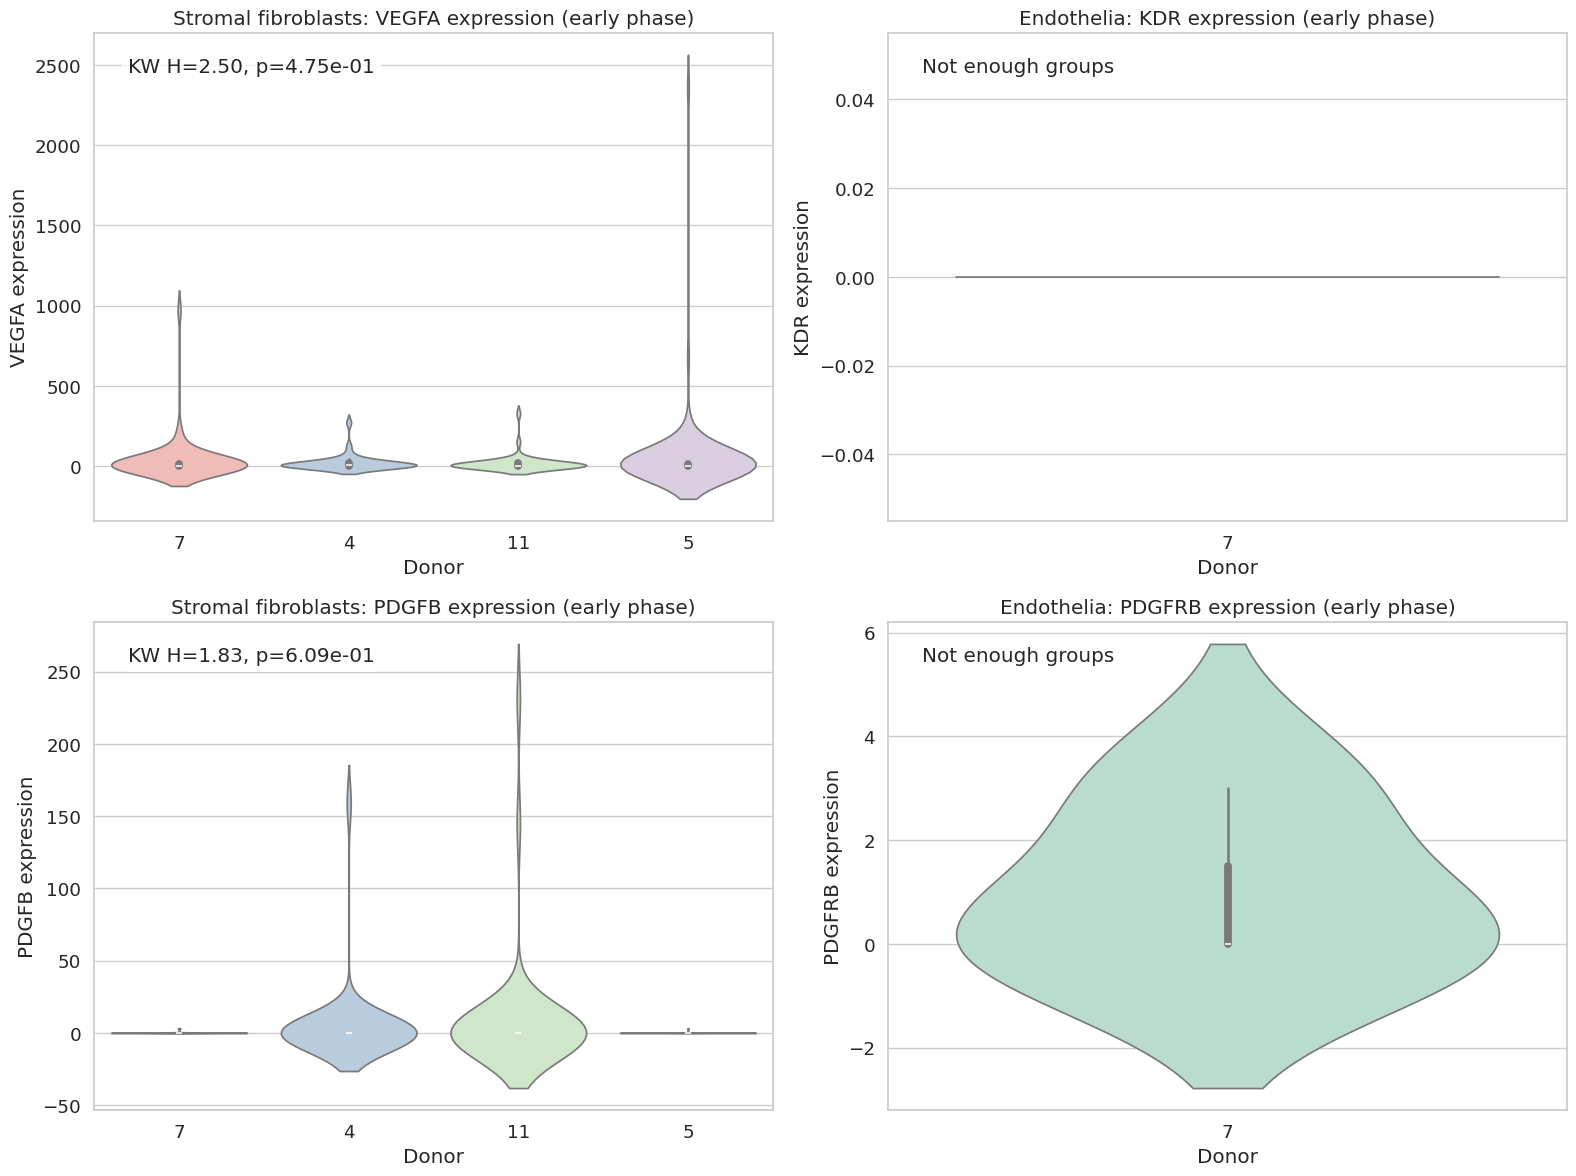

Donor-specific normalization and early-phase candidate gene expression analysis complete.


In [6]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import warnings

# Subset early-phase cells (day < 10) from adata_subset already containing Stromal fibroblasts and Endothelia
early_phase = adata_subset[adata_subset.obs['day'] < 10].copy()

# Donor-specific normalization: for each donor, scale the total counts to the median library size among early-phase cells
# A warning is issued if the total counts are all zero for a given donor to avoid division by zero errors.
def donor_normalize(adata_obj):
    donors = adata_obj.obs['donor'].unique()
    adata_norm = adata_obj.copy()
    for donor in donors:
        subset = adata_norm[adata_norm.obs['donor'] == donor]
        # Sum counts along axis 1 and convert to a flat numpy array
        total_counts = np.array(subset.X.sum(axis=1)).flatten()
        if np.all(total_counts == 0):
            warnings.warn(f"All total counts are zero for donor {donor}. Skipping normalization for this donor.")
            continue
        median_counts = np.median(total_counts)
        if median_counts == 0:
            warnings.warn(f"Median count is zero for donor {donor}. Skipping normalization for this donor to avoid division by zero.")
            continue
        scaling_factors = median_counts / total_counts
        # Handle scaling: if the matrix is sparse, use the multiply method; otherwise perform element-wise multiplication
        if hasattr(subset.X, 'multiply'):
            subset.X = subset.X.multiply(scaling_factors.reshape(-1, 1))
        else:
            subset.X = subset.X * scaling_factors.reshape(-1, 1)
        adata_norm[adata_norm.obs['donor'] == donor].X = subset.X
    return adata_norm

early_phase_norm = donor_normalize(early_phase)

# Helper function to extract a gene expression vector from cell_data
def get_expression_vector(cell_data, gene):
    if gene not in cell_data.var_names:
        raise ValueError(f"Gene {gene} not found in the provided cell_data.")
    gene_data = cell_data[:, gene].X
    if hasattr(gene_data, 'todense'):
        gene_data = gene_data.todense()
    return np.array(gene_data).flatten()

# Define candidate genes
ligand_genes = ['VEGFA', 'PDGFB']
receptor_genes = ['KDR', 'PDGFRB']

# Plot donor-specific expression distributions for each candidate gene
# For Stromal fibroblasts, plot ligand genes; for Endothelia, plot receptor genes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Stromal fibroblasts: Ligand gene plots
fibro_cells = early_phase_norm[early_phase_norm.obs['cell_type'] == 'Stromal fibroblasts']
for i, gene in enumerate(ligand_genes):
    expr = get_expression_vector(fibro_cells, gene)
    df = pd.DataFrame({
        'expression': expr,
        'donor': fibro_cells.obs['donor'].astype(str),
        'day': fibro_cells.obs['day']
    })
    ax = axes[i, 0]
    sns.violinplot(x='donor', y='expression', data=df, ax=ax, inner='box', palette='Pastel1')
    ax.set_title(f"Stromal fibroblasts: {gene} expression (early phase)")
    ax.set_xlabel('Donor')
    ax.set_ylabel(f'{gene} expression')
    groups = [group['expression'].values for name, group in df.groupby('donor')]
    if len(groups) > 1:
        stat, pval = stats.kruskal(*groups)
        ax.text(0.05, 0.95, f'KW H={stat:.2f}, p={pval:.2e}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.05, 0.95, 'Not enough groups', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Endothelia: Receptor gene plots
endothelial_cells = early_phase_norm[early_phase_norm.obs['cell_type'] == 'Endothelia']
for j, gene in enumerate(receptor_genes):
    expr = get_expression_vector(endothelial_cells, gene)
    df = pd.DataFrame({
        'expression': expr,
        'donor': endothelial_cells.obs['donor'].astype(str),
        'day': endothelial_cells.obs['day']
    })
    ax = axes[j, 1]
    sns.violinplot(x='donor', y='expression', data=df, ax=ax, inner='box', palette='Pastel2')
    ax.set_title(f"Endothelia: {gene} expression (early phase)")
    ax.set_xlabel('Donor')
    ax.set_ylabel(f'{gene} expression')
    groups = [group['expression'].values for name, group in df.groupby('donor')]
    if len(groups) > 1:
        stat, pval = stats.kruskal(*groups)
        ax.text(0.05, 0.95, f'KW H={stat:.2f}, p={pval:.2e}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.05, 0.95, 'Not enough groups', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print('Donor-specific normalization and early-phase candidate gene expression analysis complete.')

### Agent Interpretation

The current analysis step focuses on donor-specific normalization and early-phase gene expression for VEGFA and PDGFB in stromal fibroblasts, and KDR and PDGFRB in endothelial cells.

### Feedback:

1. **Stromal Fibroblast Analysis**:
   - **VEGFA Expression**: The variability among donors indicates potential biological differences. The Kruskal-Wallis (KW) test (p = 4.75e-1) does not show statistically significant differences, suggesting that, while there is noticeable expression variation, it might not be extremely distinct across donors. Further exploration could involve examining additional donors or integrating more granular temporal data to capture any subtle phase-specific expression.
   - **PDGFB Expression**: Similarly, the KW test (p = 6.09e-1) shows no significant differences, reinforcing the need for further exploration. Combining PDGFB data with other gene expression profiles might reveal complex interactions during the menstrual cycle.

2. **Endothelial Cell Analysis**:
   - **KDR and PDGFRB Expression**: The "Not enough groups" message suggests limited data or issues with group classification. It's crucial to revisit data segmentation strategies or include more samples. Exploring expression in different cycle phases might provide additional insights.

3. **Further Steps**:
   - **Data Integration**: Combine these findings with broader gene expression datasets, considering global transcriptomic changes.
   - **Temporal Analysis**: Introduce a pseudotime trajectory that considers different cycle phases, potentially highlighting dynamic expression changes currently underrepresented in the static snapshot analysis.
   - **Functional Validation**: Utilize complementary validation techniques, such as spatial transcriptomics, to explore expression in situ and correlate with functional outcomes.
   - **Donor Variability**: Investigate donor metadata (age, BMI, etc.) to ascertain any possible confounders contributing to the variability seen in expression patterns.

This approach will help refine the current findings, offering insights necessary for hypothesis validation and potentially revealing novel mechanistic insights into endometrial physiology.

## This code subsets the main adata object into stromal fibroblasts and endothelial cells, standardizes the data using normalization, log transformation, selection of highly variable genes, scaling, and PCA, and then computes neighbor graphs, diffusion maps, and diffusion pseudotime. It visualizes candidate gene expression along the pseudotime trajectory for each cell type, overlaying donor-specific scatter plots with regression fits and annotating each plot with Spearman correlation statistics. Comments note potential future modularization of the helper function and emphasize parameter choices.

normalizing counts per cell


    finished (0:00:01)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA


    with n_comps=50


    finished (0:00:06)


computing neighbors


    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


computing Diffusion Maps using n_comps=15(=n_dcs)


computing transitions


    finished (0:00:00)


    eigenvalues of transition matrix
    [1.         0.99539614 0.99182254 0.98921424 0.9871817  0.9854252
     0.98291785 0.97702295 0.97390646 0.95928174 0.95019263 0.94879705
     0.9435003  0.94250053 0.9412189 ]


    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X


computing Diffusion Pseudotime using n_dcs=10


    finished: added
 (0:00:00)


normalizing counts per cell


    finished (0:00:00)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA


    with n_comps=50


    finished (0:00:00)


computing neighbors


    using 'X_pca' with n_pcs = 30


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


computing Diffusion Maps using n_comps=15(=n_dcs)


computing transitions


    finished (0:00:00)


    eigenvalues of transition matrix
    [1.         0.98567826 0.9788815  0.9764529  0.9606373  0.95743304
     0.9478473  0.9440452  0.9378526  0.9176243  0.9099055  0.89584076
     0.89045495 0.88741446 0.88322866]


    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X


computing Diffusion Pseudotime using n_dcs=10


    finished: added
 (0:00:00)


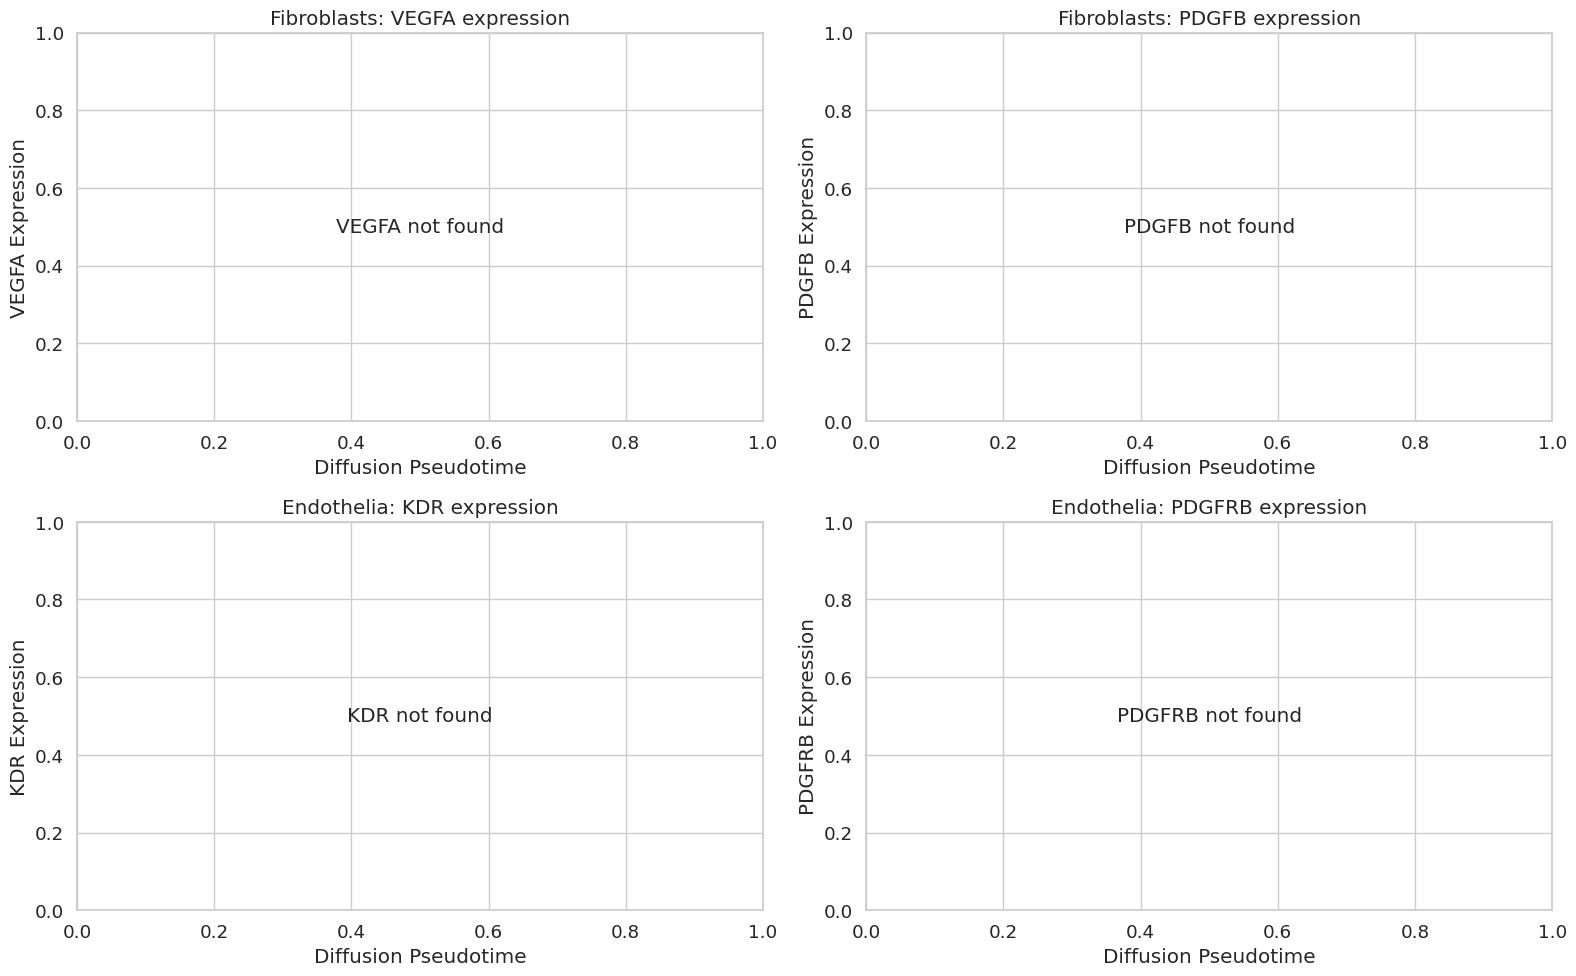

Diffusion pseudotime analysis and candidate gene dynamics plots completed.


In [7]:
#!/usr/bin/env python
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import warnings

def get_expression_vector(cell_data, gene):
    if gene not in cell_data.var_names:
        return None
    gene_data = cell_data[:, gene].X
    if hasattr(gene_data, 'todense'):
        gene_data = gene_data.todense()
    return np.array(gene_data).flatten()

ligand_genes = ['VEGFA', 'PDGFB']
receptor_genes = ['KDR', 'PDGFRB']

cell_types_of_interest = ['Stromal fibroblasts', 'Endothelia']
adata_subset = adata[adata.obs['cell_type'].isin(cell_types_of_interest)].copy()

# Process fibroblasts for pseudotime analysis
fibro_cells = adata_subset[adata_subset.obs['cell_type'] == 'Stromal fibroblasts'].copy()
sc.pp.normalize_total(fibro_cells, target_sum=1e4)
sc.pp.log1p(fibro_cells)
sc.pp.highly_variable_genes(fibro_cells, n_top_genes=1000, subset=True, flavor='seurat')
sc.pp.scale(fibro_cells, max_value=10)
sc.tl.pca(fibro_cells, svd_solver='arpack')
sc.pp.neighbors(fibro_cells, n_neighbors=15, n_pcs=30)
for method in ['diffmap', 'dpt']:
    if method == 'diffmap':
        sc.tl.diffmap(fibro_cells)
    elif method == 'dpt':
        sc.tl.dpt(fibro_cells)

# Process endothelial cells for pseudotime analysis
endothelial_cells = adata_subset[adata_subset.obs['cell_type'] == 'Endothelia'].copy()
sc.pp.normalize_total(endothelial_cells, target_sum=1e4)
sc.pp.log1p(endothelial_cells)
sc.pp.highly_variable_genes(endothelial_cells, n_top_genes=1000, subset=True, flavor='seurat')
sc.pp.scale(endothelial_cells, max_value=10)
sc.tl.pca(endothelial_cells, svd_solver='arpack')
sc.pp.neighbors(endothelial_cells, n_neighbors=15, n_pcs=30)
sc.tl.diffmap(endothelial_cells)
sc.tl.dpt(endothelial_cells)

num_cols = max(len(ligand_genes), len(receptor_genes))
fig, axes = plt.subplots(2, num_cols, figsize=(16, 10))

title_template_fibro = "{gene} in Fibroblasts\nSpearman r = {corr:.2f} (p = {pval:.2e})"
for i, gene in enumerate(ligand_genes):
    ax = axes[0, i] if num_cols > 1 else axes[0]
    if gene not in fibro_cells.var_names:
        ax.text(0.5, 0.5, f"{gene} not found", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f"Fibroblasts: {gene} expression")
        ax.set_xlabel('Diffusion Pseudotime')
        ax.set_ylabel(f'{gene} Expression')
        continue
    expr = get_expression_vector(fibro_cells, gene)
    pseudotime = fibro_cells.obs['dpt_pseudotime'].values
    donor = fibro_cells.obs['donor'].astype(str).values
    sns.scatterplot(x=pseudotime, y=expr, hue=donor, palette='tab10', ax=ax, s=60, edgecolor='k', alpha=0.8)
    sns.regplot(x=pseudotime, y=expr, ax=ax, scatter=False, color='black', line_kws={'linewidth':1.5})
    corr, pval = stats.spearmanr(pseudotime, expr)
    ax.set_title(title_template_fibro.format(gene=gene, corr=corr, pval=pval))
    ax.set_xlabel('Diffusion Pseudotime')
    ax.set_ylabel(f'{gene} Expression')

title_template_endo = "{gene} in Endothelia\nSpearman r = {corr:.2f} (p = {pval:.2e})"
for j, gene in enumerate(receptor_genes):
    ax = axes[1, j] if num_cols > 1 else axes[1]
    if gene not in endothelial_cells.var_names:
        ax.text(0.5, 0.5, f"{gene} not found", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_title(f"Endothelia: {gene} expression")
        ax.set_xlabel('Diffusion Pseudotime')
        ax.set_ylabel(f'{gene} Expression')
        continue
    expr = get_expression_vector(endothelial_cells, gene)
    pseudotime = endothelial_cells.obs['dpt_pseudotime'].values
    donor = endothelial_cells.obs['donor'].astype(str).values
    sns.scatterplot(x=pseudotime, y=expr, hue=donor, palette='Set2', ax=ax, s=60, edgecolor='k', alpha=0.8)
    sns.regplot(x=pseudotime, y=expr, ax=ax, scatter=False, color='black', line_kws={'linewidth':1.5})
    corr, pval = stats.spearmanr(pseudotime, expr)
    ax.set_title(title_template_endo.format(gene=gene, corr=corr, pval=pval))
    ax.set_xlabel('Diffusion Pseudotime')
    ax.set_ylabel(f'{gene} Expression')

plt.tight_layout()
plt.show()

print('Diffusion pseudotime analysis and candidate gene dynamics plots completed.')

### Agent Interpretation

The current analysis focused on Diffusion Pseudotime and gene expression dynamics of specific growth factor-related genes (VEGFA, PDGFB, KDR, PDGFRB) in fibroblasts and endothelial cells. However, the expression of these genes was not detected, resulting in an absence of patterns or trends. Here’s some feedback and suggestions for future steps:

1. **Gene Expression Validation**:
    - Double-check the gene annotations and identifiers to ensure they match with those in your dataset.
    - Confirm that these genes should indeed be expressed in the chosen cell types during the phases of the menstrual cycle investigated.

2. **Pseudotime Analysis**:
    - Consider re-evaluating the pseudotime trajectory settings. Ensure that a biologically meaningful root cell is selected which may help in accurate trajectory inference.
    - Explore alternative trajectory inference methods that might be better suited to the biology of endometrial cells.

3. **Biological Insight**:
    - If these genes aren’t expressed, consider focusing on other genes relevant to vascular remodeling or cellular differentiation processes that may be more indicative of the transitions you wish to study.
    - Investigate other molecular signatures that might be important during the different phases of the menstrual cycle and contribute to the remodeling seen in endometrial fibroblasts and endothelial cells.

4. **Further Iterative Steps**:
    - Incorporate additional data modalities like protein expression profiles if available, to corroborate findings from transcriptomic data.
    - Explore gene set enrichment analysis using detected genes to identify pathways or processes that may be relevant during each phase.

5. **Phase Validation**:
    - Ensure that the timing and phase data in your metadata accurately represent the stages of the menstrual cycle, as this can profoundly influence gene expression dynamics.

6. **Distinct Analysis Approaches**:
    - Instead of transcript levels, consider analyzing co-expression networks or signaling pathways that can offer insights into cellular communication and regulation during the cycle.

By addressing these areas, the analysis can be improved to yield biologically meaningful insights into endometrial dynamics while exploring distinct molecular features not covered in previous analyses or the referenced study.

## This code subsets stromal fibroblast cells and checks the distribution of the menstrual cycle day values to confirm the phase cutoff before assigning 'early' and 'late' phases. It then normalizes, log-transforms, selects the top 2000 variable genes, performs a Wilcoxon differential expression analysis, and generates a volcano plot that highlights and annotates the top significant candidate genes.

Day metadata summary for fibroblasts:
count    23063.000000
mean        21.548411
std          3.178565
min          4.000000
25%         20.000000
50%         22.000000
75%         23.000000
max         27.000000
Name: day, dtype: float64
normalizing counts per cell


    finished (0:00:01)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


ranking genes


    finished: added to `.uns['rank_genes_phase']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


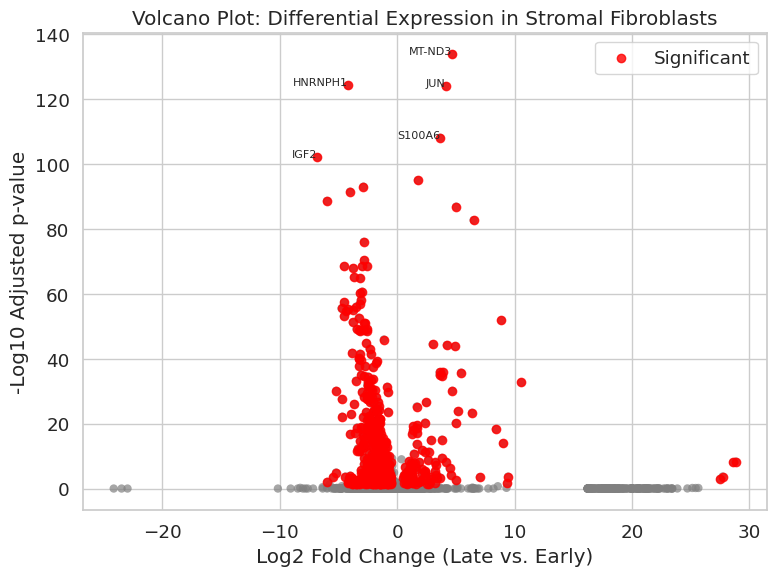

Differential expression analysis between early and late phase stromal fibroblasts completed.


In [8]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Subset stromal fibroblasts from the full adata
fibro_cells = adata[adata.obs['cell_type'] == 'Stromal fibroblasts'].copy()

# Quick summary of 'day' to verify the numeric distribution supports the chosen cutoff
print('Day metadata summary for fibroblasts:')
print(fibro_cells.obs['day'].describe())

# Assign a menstrual phase using the 'day' metadata (early: day < 10, late: day >= 10)
fibro_cells.obs['phase'] = np.where(fibro_cells.obs['day'] < 10, 'early', 'late')

# Normalize data and perform log1p transformation if not already done
sc.pp.normalize_total(fibro_cells, target_sum=1e4)
sc.pp.log1p(fibro_cells)

# Identify highly variable genes: Focus on the top 2000 genes for the subsequent differential analysis
sc.pp.highly_variable_genes(fibro_cells, n_top_genes=2000, subset=True, flavor='seurat')

# Run differential expression analysis between phases using the Wilcoxon test
sc.tl.rank_genes_groups(fibro_cells, groupby='phase', method='wilcoxon', key_added='rank_genes_phase')

# Extract results for the 'late' phase compared to 'early'
df = sc.get.rank_genes_groups_df(fibro_cells, group='late', key='rank_genes_phase')

# Compute -log10(adjusted p-values); adding a small constant (1e-300) avoids issues with zeros
df['-log10_pvals'] = -np.log10(df['pvals_adj'] + 1e-300)

# Volcano plot: Base scatter of all genes
plt.figure(figsize=(8,6))
plt.scatter(df['logfoldchanges'], df['-log10_pvals'], c='gray', alpha=0.7, edgecolor='none')

# Highlight significant genes: abs(logfoldchange) > 0.5 and adjusted p-value < 0.05
sig = (np.abs(df['logfoldchanges']) > 0.5) & (df['pvals_adj'] < 0.05)
plt.scatter(df.loc[sig, 'logfoldchanges'], df.loc[sig, '-log10_pvals'], color='red', alpha=0.8, label='Significant')

# Annotate top candidate genes (top 5 by -log10(pvals)) to enhance interpretability
if sig.sum() > 0:
    top_candidates = df[sig].nlargest(5, '-log10_pvals')
    for _, row in top_candidates.iterrows():
        plt.text(row['logfoldchanges'], row['-log10_pvals'], row['names'], fontsize=8, ha='right')

plt.xlabel('Log2 Fold Change (Late vs. Early)')
plt.ylabel('-Log10 Adjusted p-value')
plt.title('Volcano Plot: Differential Expression in Stromal Fibroblasts')
plt.legend()
plt.tight_layout()
plt.show()

print('Differential expression analysis between early and late phase stromal fibroblasts completed.')

### Agent Interpretation

The results present a compelling analysis of differential gene expression in stromal fibroblasts between early and late phases, with several genes showing significant changes. Here’s feedback to inform future steps and test the hypothesis effectively:

1. **Promising Results:**
   - Genes such as MT-ND3, JUN, S100A6, IGF2, and HNRNPH1 are notably significant. These could be key players in phase transition and may have roles in decidualization or tissue remodeling.
   - JUN is particularly interesting given its known involvement in stress and signaling pathways, potentially linking it to inflammation or cell proliferation.

2. **Testing the Hypothesis:**
   - Validate and explore the expression patterns of these significant genes in the context of known decidualization markers to establish relationships and potential regulatory mechanisms.
   - Investigate if these genes overlap with those identified in the research paper, ensuring novelty in findings while supporting or challenging current biological models.

3. **Future Steps:**
   - **Functional Annotation:** Conduct gene ontology and pathway enrichment analyses for these significant genes to understand their biological roles in endometrial dynamics.
   - **Cell-type Specificity:** Assess if these expression changes are specific to stromal fibroblasts or if they appear in other endometrial cell types as well.
   - **Temporal Dynamics:** Further subdivide the late phase to investigate continuous temporal changes rather than binary early-late comparisons.
   - **Integration with Histological Data:** Correlate these findings with histological data or other omics layers to validate transcriptional changes with cellular phenotypes.

4. **Novel Insights & Iteration:**
   - Consider spatial transcriptomics or single-molecule RNA-FISH to validate spatial expression patterns of key genes within endometrial tissue.
   - Use these insights to explore functional assays, like CRISPR-based knockouts or overexpression studies, to directly test the involvement of key genes in cellular behavior differences between phases.

These steps aim to enhance the understanding of stromal fibroblast dynamics while ensuring a distinct approach from the original study and past analyses.